# Chapter 2. 자연어와 단어의 분산 표현

In [62]:
# 예제 코드를 위한 사전 작업
import numpy as np
import matplotlib.pyplot as plt
import time

### 2.1 자연어 처리란?
- 자연어(Natural Language): 우리가 평소에 쓰는 말
- 자연어 처리 (Natural Language Processing): 우리의 말을 컴퓨터에게 이해시키기 위한 기술(분야)
- 컴퓨터에게 단어의 의미를 이해시키는 방법?
    - 시소러스(유의어 사전)을 활용
    - 통계 기반
    - 추론 기반 (word2vec)

### 2.2 시소러스
- 시소러스: 각 단어의 관계를 **그래프 구조**로 정의한 유의어 사전. (ex. WordNet)
- 시소러스의 문제점
    - 시대 변화에 대응하기 어려움 (새로운 단어, 잊혀지는 옜말, 시대에 따라 의미가 변하는 단어)
    - 구축에 엄청난 인적 비용이 발생
    - 단어의 미묘한 차이를 표현할 수 없음 (비슷한 단어들이라도 미묘한 차이가 있는 법)

### 2.3 통계 기반 기법
- 말뭉치(corpus) : 자연어 처리 연구나 애플리케이션을 염두에 두고 수집된 텍스트 데이터. 텍스트 데이터에 대한 추가 정보가 포함되는 경우가 있음
- 전처리(preprocessing): 텍스트 데이터를 단어로 분할하고 그 분할된 단어들을 단어 ID 목록으로 변환하는 일

In [6]:
def preprocess(text):
    text = text.lower()
    # EOS(End Of Sentence)를 표현하기 위해 마침표 앞에 공백을 추가해준다
    text = text.replace('.', ' .')
    words = text.split()
    word_to_id = {}
    id_to_word = {}
    idx = 0
    
    for word in words:
        if word not in word_to_id:
            new_id = idx
            idx += 1
            word_to_id[word] = new_id
            id_to_word[new_id] = word
            
    corpus = np.array([word_to_id[w] for w in words])
    
    return corpus, word_to_id, id_to_word

In [40]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


- 분산 표현(Distributional Representation)
    - 단어를 '단어의 의미'를 정확하게 파악할 수 있는 벡터로 표현하는 것
    - 고정 길이의 밀집 벡터(Dense Vector)로 표현
    - '단어의 의미는 주변 단어에 의해 형성된다'는 분포가설(distributional hypothesis) 기반
    - '단어 자체에는 의미가 없고, 그 단어가 사용된 '맥락'이 의미를 형성한다!
- 통계 기반(Statistical based) 기법: 그 주변에 어떤 단어가 몇 번이나 등장하는지를 세어 집계하는 방법
- 동시발생 행렬(co-occurrence matrix)
    - 각 단어의 맥락에 해당하는 단어의 빈도로 단어들을 벡터로 표현한 행렬
    - 윈도우 크기(window size): 맥락의 크기(주변 단어를 몇 개나 포함할지)

In [11]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        # window size만큼 앞 뒤로 맥락을 확인한다
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
                
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
                
    return co_matrix

In [41]:
vocab_size = len(word_to_id)
co_matrix = create_co_matrix(corpus, vocab_size)

print(co_matrix)

[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]


- 코사인 유사도(Cosine Similarity)
    - 벡터의 유사도를 측정하는 방법 중 하나

$$similarity (x,y) = {x∙y  \over ||x||∙||y||} = {
    {{x_1 y_1}+...+{x_n y_n}} \over {\sqrt {{{x_1}^2}+...+{x_n}^2}}{\sqrt {{{y_1}^2}+...+{y_n}^2}}}$$

In [16]:
def cos_similarity(x, y, eps=1e-8):
    # 'Divide by Zero' 문제 해결을 위해 작은 값(eps)를 분자, 분모에 더해준다
    nx = x / np.sqrt(np.sum(x**2) + eps)
    ny = y / np.sqrt(np.sum(y**2) + eps)
    
    return np.dot(nx, ny)

In [42]:
c0 = co_matrix[word_to_id['you']]
c1 = co_matrix[word_to_id['i']]

print(cos_similarity(c0, c1))

0.7071067758832467


In [45]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # 검색어가 corpus 안에 있는 지 확인한다
    if query not in word_to_id:
        print("{}(을)를 찾을 수 없습니다.".format(query))
        return
    
    print("[query] {}".format(query))
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]
    
    # 코사인 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)
        
    count = 0
    for i in (-1 * similarity).argsort():
        if id_to_word[i] == query:
            continue
        print("{}: {}".format(id_to_word[i], similarity[i]))
        
        count += 1
        if count >= top:
            return

cf. `argsort()` : numpy 배열의 원소를 오름 차순으로 정렬. (배열의 index를 반환)

In [46]:
most_similar('you', word_to_id, id_to_word, co_matrix, top = 5)

[query] you
goodbye: 0.7071067758832467
i: 0.7071067758832467
hello: 0.7071067758832467
say: 0.0
and: 0.0


### 2.4 통계 기반 기법 개선하기
- **점별 상호 정보량** (PMI, Pointwise Mutual Information)
    - 고빈도 단어가 관련성이 강하다고 평가되는 문제를 해결하기 위한 척도

$$ PMI(x,y) =  log_2 {P(x, y)  \over P(x)∙P(y)} 
= log_2 {{C(x,y) \over N} \over {C(x) \over N}{C(y) \over N}}
= log_2 {{C(x,y)∙N} \over C(x)C(y)}
$$

- **양의 상호정보량** (PPMI, Positive PMI)
    - PMI에서 두 단어의 동시발생 횟수가 0인 경우 PMI가 -∞인 것을 방지하기 위한 척도
    - PMI가 음수일 때는 0으로 취급
    - 말뭉치의 어휘 수가 증가함에 따라 각 단어 벡터의 차원 수도 증가한다는 문제가 있음
    - 원소 대부분이 0임 → 각 원소의 '중요도'가 낮음. 노이즈에 약하고 견고하지 못함

$$ PPMI(x, y) = max(0, PMI(x,y))$$

In [52]:
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C, dtype= np.float32)
    N = np.sum(C)
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total // 100) == 0:
                    print("{} 완료".format(100 * cnt / total, "%.1f"))
    return M

In [54]:
np.set_printoptions(precision=3)  # 유효 자릿수를 세 자리로 표시
W = ppmi(co_matrix)
print(W)

[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


- 차원 감소 (Dimenstionality Reduction)
    - '중요한 정보'는 최대한 유지하면서 벡터의 차원을 줄이는 방법
    - 특잇값분해(Singular Value Decomposition)를 이용하여 분해할 수 있음
    - 중요도가 낮은 원소(특잇값이 작은 원소)를 깎아내는 방법

In [63]:
# numpy를 이용한 SVD 계산 (느림)
slow_start = time.time()
U, S, V = np.linalg.svd(W)
print(time.time() - slow_start)

0.05451011657714844


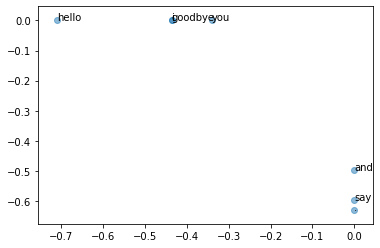

In [64]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

In [65]:
# sklearn 모듈의 고속 SVD를 이용한 SVD 계산 
from sklearn.utils.extmath import randomized_svd

fast_start = time.time()
U, S, V = randomized_svd(W, n_components=100, n_iter=5, random_state=None)
print(time.time() - fast_start)

0.04313397407531738


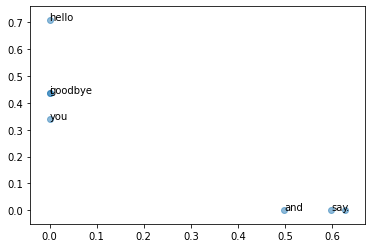

In [66]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
    
plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

- PTB(Penn Treebank) 데이터셋
    - word2vec의 발명자 Tomas Mikolov가 만든 말뭉치
    - 텍스트 파일로 제공
    - 몇 가지 전처리가 되어 있음
        - 희소한 단어를 `<unk>` 라는 특수 문자로 치환
        - 구체적인 숫자를 "N"으로 대체
    - 한 문장이 하나의 줄로 저장되어 있음 (각 문장을 연결한 '하나의 큰 시계열 데이터'로 취급)
    각 문장의 끝에  `<eos>` 라는 특수 문자 삽입